Descripción del conjunto de datos, El conjunto de datos consta de las siguientes columnas:

**-work_year [categórico]:** El año en el que se pagó el salario.  
**-experience_level [categórico]:** El nivel de experiencia en el trabajo durante el año.  
**-employment_type [categórico]:** El tipo de empleo para el puesto.  
**-job_title [categórico]:** El puesto en el que se trabajó durante el año.  
**-salary [numérico]:** El monto total del salario bruto pagado.  
**-salary_currency [categórico]:** La moneda del salario pagado como un código ISO 4217 de moneda.  
**-salaryinusd [numérico]:** El salario en USD.  
**-employee_residence [categórico]:** El país de residencia principal del empleado durante el año laboral como un código de país ISO 3166.  
**-remote_ratio [ratio]:** La cantidad total de trabajo realizado de forma remota.  
**-company_location [categórico]:** El país de la oficina principal del empleador o sucursal contratante.  
**-company_size [categórico]:** El número medio de personas que trabajaron para la empresa durante el año como un código de país ISO 3166.  

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Importar bibliotecas necesarias
import numpy as np 
import pandas as pd

# Importar bibliotecas de visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Importar bibliotecas de estadísticas
from scipy import stats
from scipy.stats import norm

# Importar bibliotecas de Machine Learning de Scikit-learn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline

# Importar bibliotecas de códigos de país
import pycountry

In [2]:
data = pd.read_csv('./ds_salaries.csv')


En este estudio, nuestro objetivo es proporcionar un análisis detallado de los salarios de los trabajos de data science utilizando un conjunto de datos que contiene información sobre salarios ajustados, el lugar de residencia del empleado, la ubicación de la empresa y otros detalles relevantes. El objetivo es explorar tendencias y patrones que puedan ayudar a los buscadores de empleo y empleadores a tomar decisiones informadas.

**1.Comprobar valores nulos y ausentes**

In [3]:
#comprobar la proporción que falta
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(20)

,Missing Ratio


**2. Comprobamos duplicados**

In [4]:
# Manejar duplicados
duplicate_rows_data = data[data.duplicated()]
print("number of duplicate rows: ", duplicate_rows_data.shape)

number of duplicate rows:  (1171, 11)


**3.Comprobamos el valor único de cada columna**

In [5]:
# Recorre cada columna y cuenta el número de valores distintos
for column in data.columns:
    num_distinct_values = len(data[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

work_year: 4 distinct values
experience_level: 4 distinct values
employment_type: 4 distinct values
job_title: 93 distinct values
salary: 815 distinct values
salary_currency: 20 distinct values
salary_in_usd: 1035 distinct values
employee_residence: 78 distinct values
remote_ratio: 3 distinct values
company_location: 72 distinct values
company_size: 3 distinct values


**4.Explorar los datos**

In [6]:
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


**5.Cambiamos el nombre del valor para que se entienda mejor**

In [7]:
data['experience_level'] = data['experience_level'].replace({
    'SE': 'Senior',
    'EN': 'Entry level',
    'EX': 'Executive level',
    'MI': 'Mid/Intermediate level',
})

data['employment_type'] = data['employment_type'].replace({
    'FL': 'Freelancer',
    'CT': 'Contractor',
    'FT' : 'Full-time',
    'PT' : 'Part-time'
})
data['company_size'] = data['company_size'].replace({
    'S': 'SMALL',
    'M': 'MEDIUM',
    'L' : 'LARGE',
})
data['remote_ratio'] = data['remote_ratio'].astype(str)
data['remote_ratio'] = data['remote_ratio'].replace({
    '0': 'On-Site',
    '50': 'Half-Remote',
    '100' : 'Full-Remote',
})

**6.Agrupamos el puesto de trabajo**

In [8]:
def assign_broader_category(job_title):
    data_engineering = ["Data Engineer", "Data Analyst", "Analytics Engineer", "BI Data Analyst", "Business Data Analyst", "BI Developer", "BI Analyst", "Business Intelligence Engineer", "BI Data Engineer", "Power BI Developer"]
    data_scientist = ["Data Scientist", "Applied Scientist", "Research Scientist", "3D Computer Vision Researcher", "Deep Learning Researcher", "AI/Computer Vision Engineer"]
    machine_learning = ["Machine Learning Engineer", "ML Engineer", "Lead Machine Learning Engineer", "Principal Machine Learning Engineer"]
    data_architecture = ["Data Architect", "Big Data Architect", "Cloud Data Architect", "Principal Data Architect"]
    management = ["Data Science Manager", "Director of Data Science", "Head of Data Science", "Data Scientist Lead", "Head of Machine Learning", "Manager Data Management", "Data Analytics Manager"]
    
    if job_title in data_engineering:
        return "Data Engineering"
    elif job_title in data_scientist:
        return "Data Science"
    elif job_title in machine_learning:
        return "Machine Learning"
    elif job_title in data_architecture:
        return "Data Architecture"
    elif job_title in management:
        return "Management"
    else:
        return "Other"

# Apply the function to the 'job_title' column and create a new column 'job_category'
data['job_category'] = data['job_title'].apply(assign_broader_category)

**7.Ajustamos el valor de los ingresos al valor actual**

Para comparar con precisión los salarios en diferentes años, es esencial tener en cuenta la inflación. La inflación es la tasa a la que aumentan los precios generales de bienes y servicios con el tiempo. Al ajustar los salarios a una moneda y año común, podemos hacer comparaciones significativas entre ellos.

Para ajustar los salarios de diferentes años a su valor actual para fines de comparación, utilizaremos un conjunto de datos que contiene información sobre salarios de empleados, años de trabajo y moneda.

Explicación:

1- Definir tasas de inflación para los mercados de Estados Unidos (EE. UU.) y globales. Estas tasas se utilizarán para ajustar los salarios en función del año y la moneda.

2- Crear una función adjust_salary() que tome una fila del conjunto de datos como entrada y calcule el salario ajustado en función del año de trabajo, el salario original y la moneda. Si el año de trabajo es 2023, el salario no necesita ajustarse y se devuelve el salario original.

3- Determinar el número de años entre el año de trabajo y 2023. Utilice la tasa de inflación correspondiente en función de la moneda, ya sea la tasa de inflación de EE. UU. o global.

4- Calcular el salario ajustado aplicando la tasa de inflación al salario original para cada año desde el año de trabajo hasta 2023.

5- Aplicar la función adjust_salary() al conjunto de datos utilizando el método apply() y crear una nueva columna 'adjusted_salary' con los valores de salario ajustados.

Al tener en cuenta la inflación, podemos obtener una mejor comprensión del valor real de los salarios en diferentes años y monedas.

In [9]:
# Tasas de inflación
us_inflation_rates = {2019: 0.0181, 2020: 0.0123, 2021: 0.0470,2022: 0.065}
global_inflation_rates = {2019: 0.0219, 2020: 0.0192, 2021: 0.0350,2022: 0.088}


# Función de ajuste del salario
def adjust_salary(row):
    year = row['work_year']
    original_salary = row['salary_in_usd']
    currency = row['salary_currency']
    
    if year == 2023:
        return original_salary
    
    years_to_2023 = 2023 - year
    
    if currency == 'USD':
        inflation_rate = us_inflation_rates[year]
    else:
        inflation_rate = global_inflation_rates[year]
        
    adjusted_salary = original_salary * (1 + inflation_rate) ** years_to_2023
    return adjusted_salary

# Aplicamos la función al conjunto de datos
data['adjusted_salary'] = data.apply(adjust_salary, axis=1)

In [10]:
# Sustituimos 'column_name' por el nombre de la columna categórica para la que desea crear variables ficticias
df = data.copy()

**8. Distribución de los empleos**

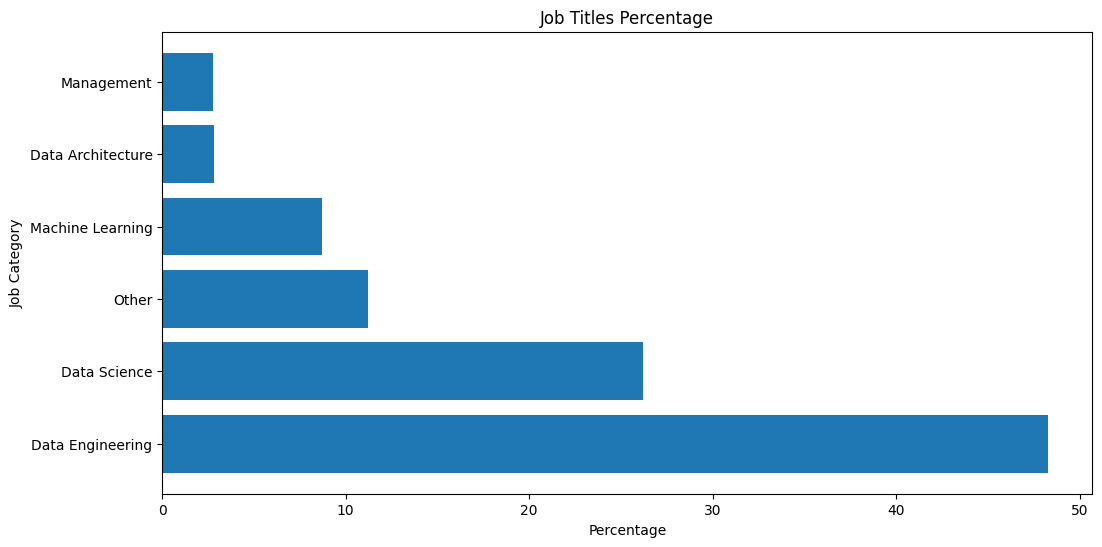

In [11]:
value_counts = data['job_category'].value_counts(normalize=True) * 100

fig, ax = plt.subplots(figsize=(12, 6))
top_n = min(17, len(value_counts))
ax.barh(value_counts.index[:top_n], value_counts.values[:top_n])
ax.set_xlabel('Percentage')
ax.set_ylabel('Job Category')
ax.set_title('Job Titles Percentage')
plt.show()

**9. Distribution across different employment types**

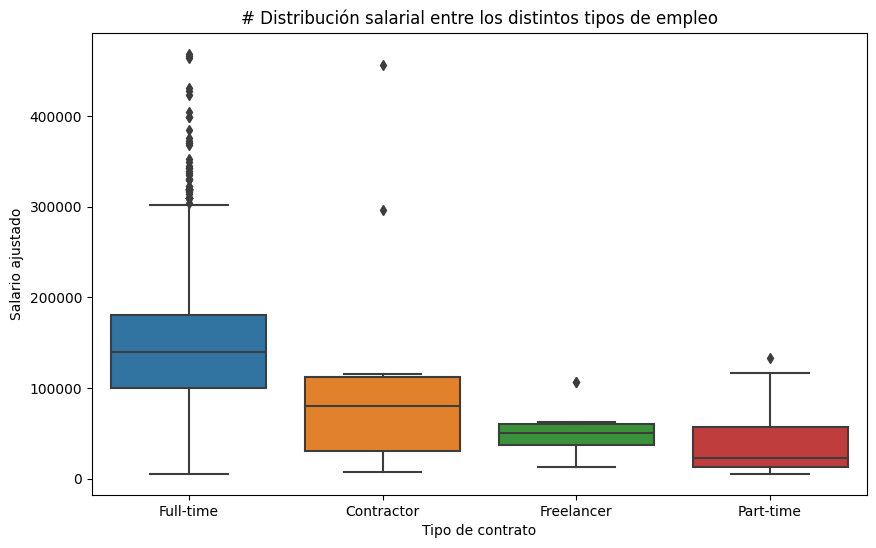

In [12]:
# Distribución salarial entre los distintos tipos de empleo
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='employment_type', y='adjusted_salary')
plt.title('# Distribución salarial entre los distintos tipos de empleo')
plt.xlabel('Tipo de contrato')
plt.ylabel('Salario ajustado')
plt.show()

**10. Distribution of Salary**

adjusted_salary: mu = 142104.98, sigma = 64616.06
adjusted_salary: Asimetría: 0.54
adjusted_salary: Curtosis: 0.95


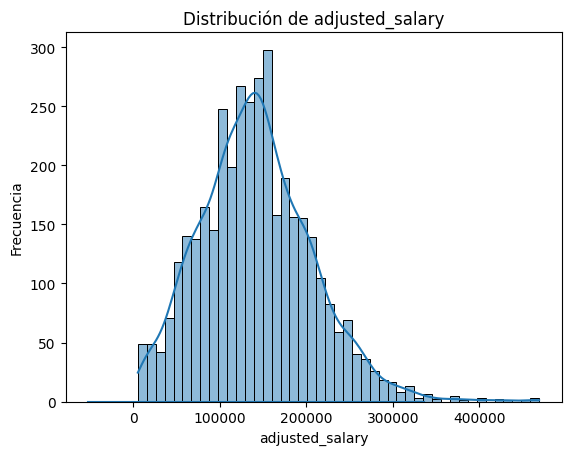

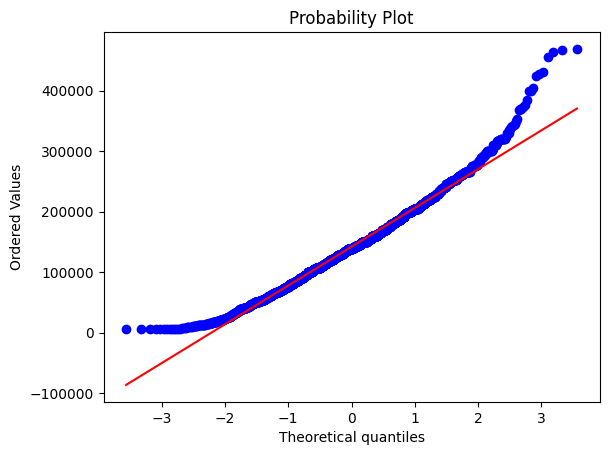

In [13]:
# Creamos una lista de las columnas a analizar
columns = ['adjusted_salary']

# Recorremos las columnas y ploteamos la distribución de cada variable
for col in columns:
    # Ploteamos la distribución de los datos
    sns.histplot(data[col], kde=True)

    # Ajustamos una distribución normal a los datos
    (mu, sigma) = stats.norm.fit(data[col])
    print('{}: mu = {:.2f}, sigma = {:.2f}'.format(col, mu, sigma))

    # Calculamos la asimetría y la curtosis de los datos
    print('{}: Asimetría: {:.2f}'.format(col, data[col].skew()))
    print('{}: Curtosis: {:.2f}'.format(col, data[col].kurt()))

    # Añadimos la distribución normal ajustada al gráfico
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = stats.norm.pdf(x, mu, sigma)
    plt.plot(x, y, label='Normal fit')

    # Añadimos etiquetas y título al gráfico
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.title('Distribución de {}'.format(col))

    # Ploteamos el QQ-plot
    fig = plt.figure()
    stats.probplot(data[col], plot=plt)

    plt.show()

**11.Boxplot y Swarmplot del salario ajustado**

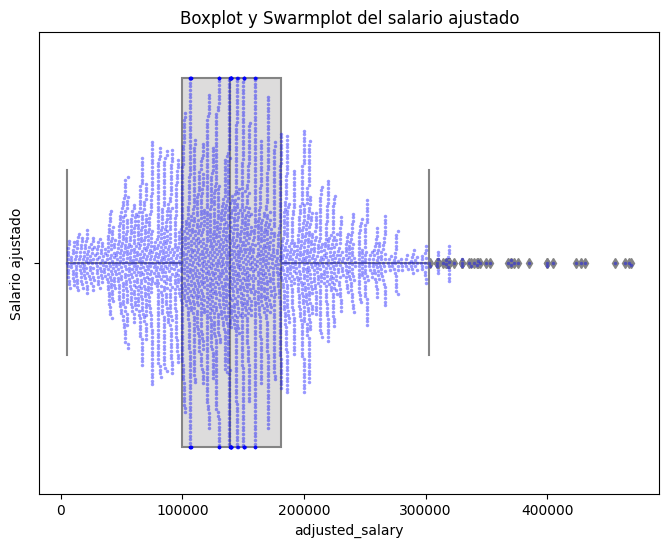

,adjusted_salary
count,3755.00
mean,142104.98
std,64624.66
min,5583.62
25%,100000.00
50%,138982.50
75%,181050.00
max,468892.10


In [14]:
# aplicamos formato al método de descripción de la columna "salario_ajustado"
formatted_data = data.loc[:, 'adjusted_salary'].describe().apply(lambda x: f'{x:.2f}')

# creamos boxplot y swarmplot para la columna 'salario_ajustado'
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['adjusted_salary'], palette='coolwarm')
sns.swarmplot(x=data['adjusted_salary'], color='blue', alpha=0.4, size=2.5)
plt.ylabel('Salario ajustado')
plt.title('Boxplot y Swarmplot del salario ajustado')
plt.show()

# apply styling to formatted data
styled_data = formatted_data.to_frame().style \
    .background_gradient(cmap='Blues') \
    .set_properties(**{'text-align': 'center', 'border': '1px solid black'})

# display styled data
display(styled_data)

**12.Salario medio por puesto de trabajo**

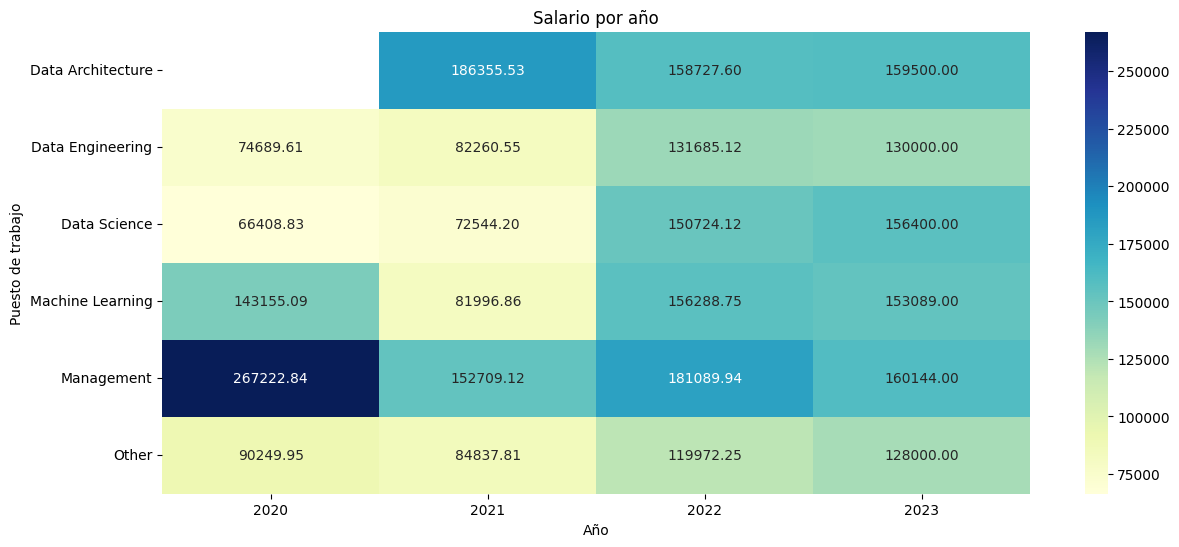

In [15]:
# Salario medio por puesto de trabajo
pivot_table = df.pivot_table(values='adjusted_salary', index='job_category', columns='work_year', aggfunc='median')
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Salario por año')
plt.xlabel('Año')
plt.ylabel('Puesto de trabajo')
plt.show()

**13. Comparación salarial entre la residencia del empleado y la sede de la empresa**

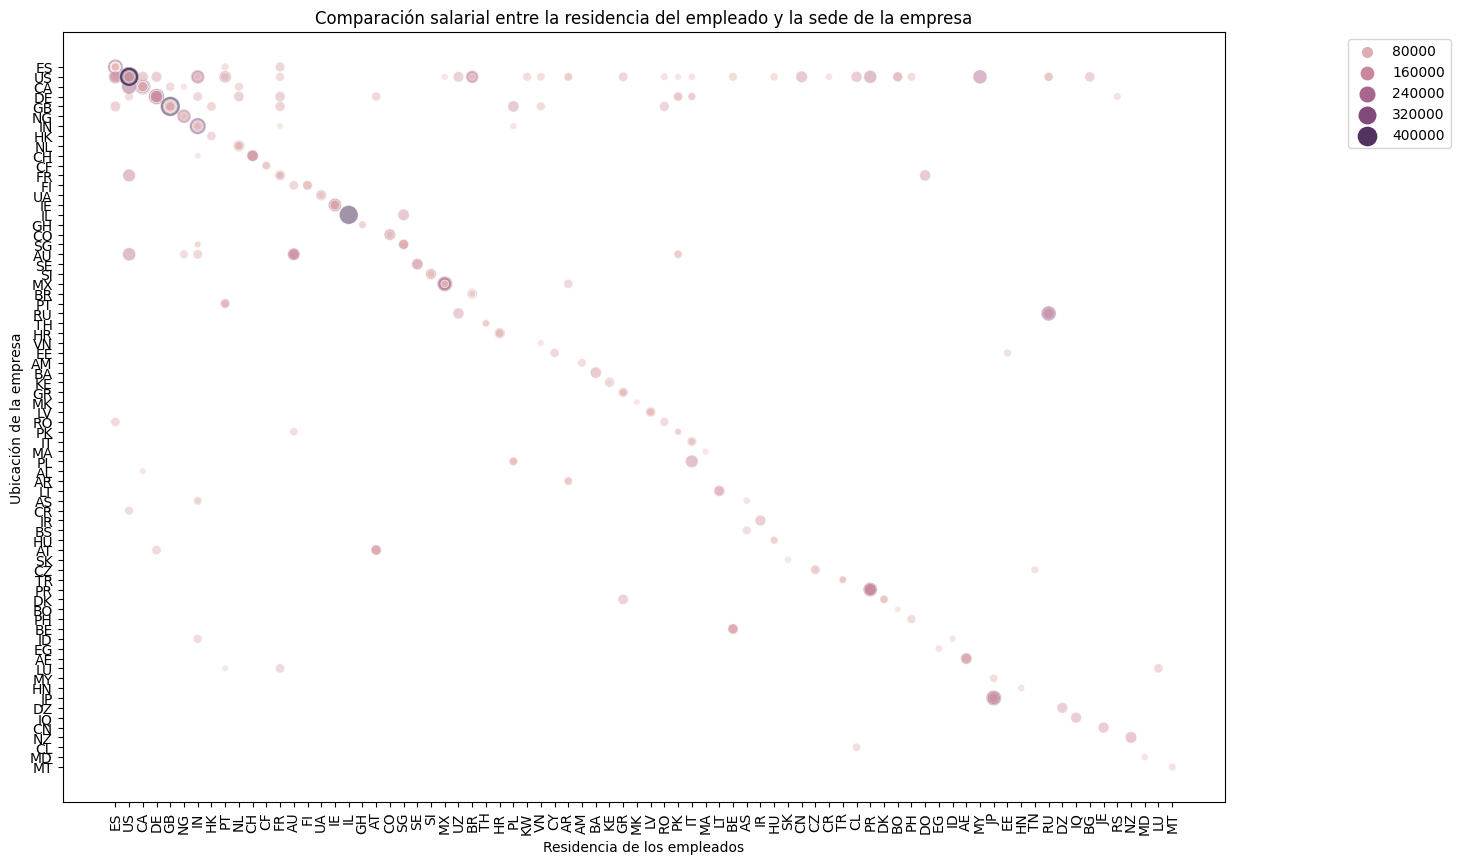

In [16]:
# Comparación salarial entre la residencia del empleado y la sede de la empresa
plt.figure(figsize=(15, 10))
sns.scatterplot(data=df, x='employee_residence', y='company_location', hue='adjusted_salary', size='adjusted_salary', sizes=(20, 200), alpha=0.5)
plt.title('Comparación salarial entre la residencia del empleado y la sede de la empresa')
plt.xlabel('Residencia de los empleados')
plt.ylabel('Ubicación de la empresa')
plt.xticks(rotation=90)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

**Geospatial Analysis**

**1.Convert the country code to the country name**

In [17]:
# Función para convertir el código de país ISO 3166 en nombre de país
def country_code_to_name(country_code):
    try:
        return pycountry.countries.get(alpha_2=country_code).name
    except:
        return country_code
    # Función para convertir el código de país en nombre completo
def country_code_to_name(code):
    try:
        country = pycountry.countries.get(alpha_2=code)
        return country.name
    except:
        return None

**2. Salario medio por ubicación de la organización**

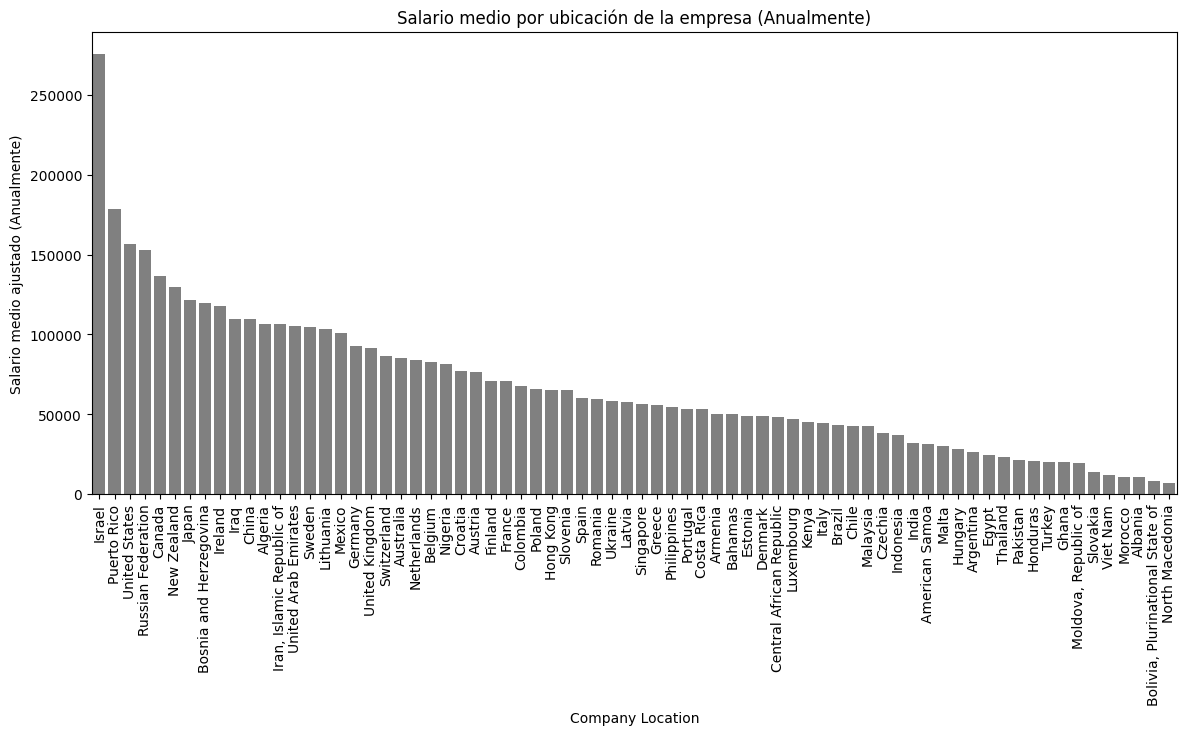

In [18]:
# Convertimos los códigos de país en nombres
df['company_location'] = df['company_location'].apply(country_code_to_name)
df['employee_residence'] = df['employee_residence'].apply(country_code_to_name)

# Salario medio por ubicación de la empresa
avg_salary_by_location = df.groupby('company_location', as_index=False)['adjusted_salary'].mean()

fig1 = px.choropleth(avg_salary_by_location,
                     locations='company_location',
                     locationmode='country names',
                     color='adjusted_salary',
                     hover_name='company_location',
                     color_continuous_scale=px.colors.sequential.Plasma,
                     title='Salario medio por ubicación de la empresa',
                     labels={'adjusted_salary': 'Average Adjusted Salary'},
                     projection='natural earth')

fig1.show()

# Salario promedio por ubicación de la empresa
avg_salary_by_location = df.groupby('company_location')['adjusted_salary'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 6))
sns.barplot(x=avg_salary_by_location.index, y=avg_salary_by_location, color='grey')
plt.title('Salario medio por ubicación de la empresa (Anualmente)')
plt.xlabel('Company Location')
plt.ylabel('Salario medio ajustado (Anualmente)')
plt.xticks(rotation=90)
plt.show()

**3.Qué país genera los salarios más altos**

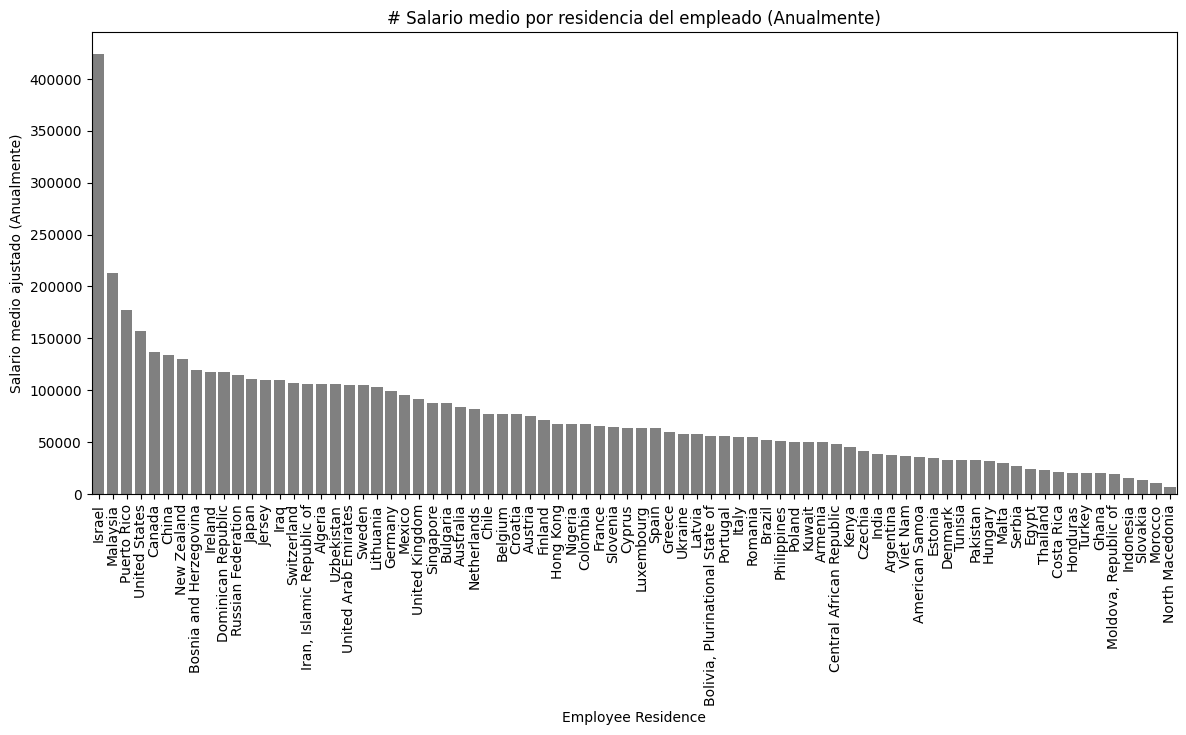

In [19]:
# Salario medio por residencia del empleado
avg_salary_by_residence = df.groupby('employee_residence', as_index=False)['adjusted_salary'].mean()

fig2 = px.choropleth(avg_salary_by_residence,
                     locations='employee_residence',
                     locationmode='country names',
                     color='adjusted_salary',
                     hover_name='employee_residence',
                     color_continuous_scale=px.colors.sequential.Plasma,
                     title='Average Salary by Employee Residence',
                     labels={'adjusted_salary': 'Average Adjusted Salary'},
                     projection='natural earth')

fig2.show()

# Salario medio por residencia del empleado
avg_salary_by_residence = df.groupby('employee_residence')['adjusted_salary'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 6))
sns.barplot(x=avg_salary_by_residence.index, y=avg_salary_by_residence.values, color='grey')
plt.title('# Salario medio por residencia del empleado (Anualmente)')
plt.xlabel('Employee Residence')
plt.ylabel('Salario medio ajustado (Anualmente)')
plt.xticks(rotation=90)
plt.show()

**Resumen de hallazgos:**

-La distribución de salarios ajustados revela que la mayoría de los profesionales de la ciencia de datos ganan entre 100.000 y 180.500 USD por año. Sin embargo, hay algunos profesionales de alto nivel que ganan significativamente más que el promedio.

-El salario promedio por ubicación de la empresa muestra que los científicos de datos que trabajan para empresas con sede en países como Israel, EE. UU. y Rusia tienden a tener salarios promedio más altos. Por otro lado, las empresas ubicadas en regiones como el sudeste asiático, África y Europa del Este pagan salarios promedio comparativamente más bajos a los profesionales de la ciencia de datos.

-El análisis del salario promedio por residencia del empleado indica que los científicos de datos que residen en países como Israel, EE. UU. y Malasia generalmente ganan salarios promedio más altos. Por el contrario, los científicos de datos que viven en países como Eslovaquia, Marruecos y Macedonia del Norte tienen salarios promedio más bajos.

-La comparación salarial entre la residencia del empleado y la ubicación de la empresa revela que si bien algunos científicos de datos ganan salarios altos trabajando para empresas con sede en países con mercados laborales bien remunerados, otros pueden necesitar trasladarse o trabajar de forma remota para beneficiarse de estas oportunidades.

En conclusión, este análisis de los salarios de los trabajos de ciencia de datos destaca el impacto de varios factores, como la ubicación de la empresa y la residencia del empleado, en las tendencias salariales. Al comprender estos patrones, los buscadores de empleo y los empleadores pueden tomar decisiones informadas sobre oportunidades laborales, paquetes de compensación y estrategias de adquisición de talentos.

**Correlación**

**1.Seleccionamos las columnas**

In [21]:
categorical_columns = ['experience_level', 'employment_type', 'remote_ratio','company_size','job_category']
numerical_columns = ['adjusted_salary']

**2.Creamos las variables ficticias**

In [22]:
dummy_variables = pd.get_dummies(df, columns=categorical_columns, drop_first=False)

**3.Preprocesamiento y escalado de los datos**

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Escalamos las columnas numéricas
scaled_numerical = scaler.fit_transform(df[numerical_columns])

# Convertimos las columnas numéricas escaladas
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_columns)

In [24]:
# Eliminamos las columnas numéricas originales
dummy_variables = dummy_variables.drop(numerical_columns, axis=1)

# Concatenamos las variables ficticias y las columnas numéricas escaladas
processed_df = pd.concat([dummy_variables, scaled_numerical_df], axis=1)
processed_df = processed_df.drop(['work_year', 'salary','salary_in_usd'], axis=1)

**4. Corelation Matrix with dummy variables**

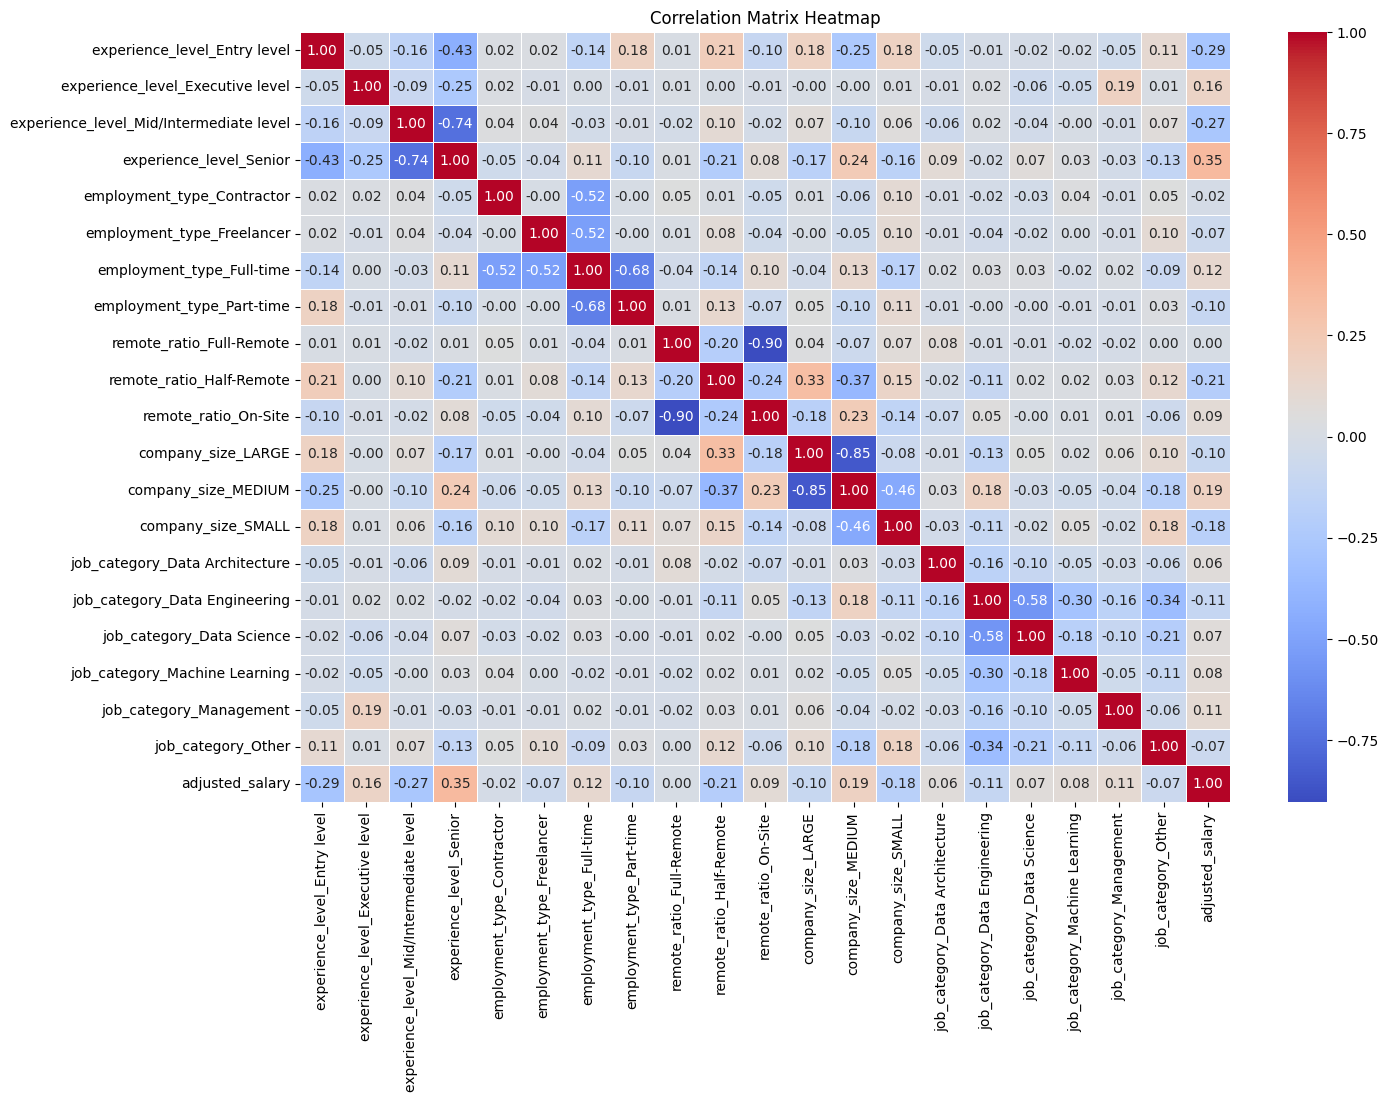

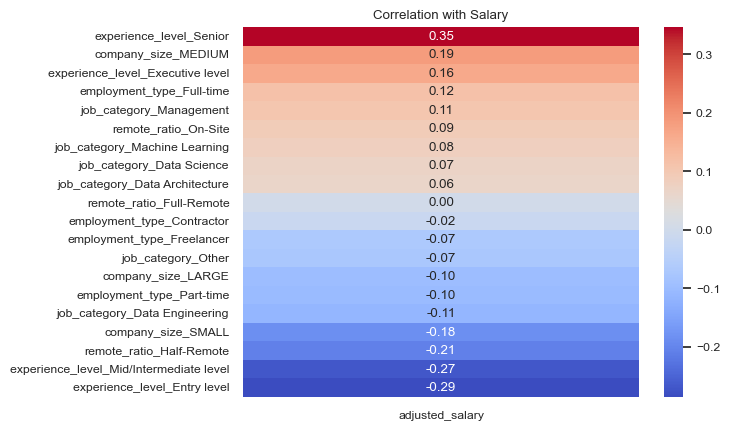

In [25]:
correlation_matrix = processed_df.corr()

#Grafico I.
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()

corr = processed_df.corr()
target_corr = corr['adjusted_salary'].drop('adjusted_salary')

# Ordenamos los valores de correlación en orden descendente
target_corr_sorted = target_corr.sort_values(ascending=False)

#Grafico II
# Creamos un mapa de calor de las correlaciones con la columna objetivo
sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Salary')
plt.show()

**Predictive Analysis**

En este estudio, nuestro objetivo es construir un modelo de aprendizaje automático que pueda predecir los salarios de trabajos de ciencia de datos en función de un conjunto de características dados, como tipo de empleo, categoría de trabajo, nivel de experiencia, residencia del empleado, proporción de trabajo remoto, ubicación de la empresa y tamaño de la empresa.  

Para lograr nuestro objetivo, utilizamos un conjunto de datos que contiene información sobre los salarios de trabajos de ciencia de datos y características relacionadas.  

El conjunto de datos se proporciona como un archivo CSV y tiene la siguiente estructura:  

employment_type (categórico): El tipo de empleo para el rol.  
job_category (categórico): El rol en el que se trabajó durante el año.  
adjusted_salary (numérico): El valor presente del salario en USD.  
experience_level (categórico): Nivel de experiencia.  
employee_residence (categórico): El país de residencia principal del empleado.  
remote_ratio (categórico): La cantidad total de trabajo realizado de forma remota.  
company_location (categórico): El país de la oficina principal del empleador o de la sucursal contratante.  
company_size (categórico): El número medio de personas que trabajaron para la empresa durante el año.  

**1. Preparación de los datos**

In [26]:
# creamos un diccionario de correspondencias entre códigos de país y nombres de país
country_map = {}
for country in pycountry.countries:
    country_map[country.alpha_2] = country.name
# reemplazamos los valores de la columna 'employee_residence' utilizando el diccionario
data['employee_residence'] = data['employee_residence'].replace(country_map)
data['company_location'] = data['company_location'].replace(country_map)

In [27]:
df = data.copy()
df = df.drop(['work_year','salary','salary_currency','salary_in_usd','salary_in_usd','job_title'], axis=1)

In [28]:
df.head()

,experience_level,employment_type,employee_residence,remote_ratio,company_location,company_size,job_category,adjusted_salary
0,Senior,Full-time,Spain,Full-Remote,Spain,LARGE,Other,85847.0
1,Mid/Intermediate level,Contractor,United States,Full-Remote,United States,SMALL,Machine Learning,30000.0
2,Mid/Intermediate level,Contractor,United States,Full-Remote,United States,SMALL,Machine Learning,25500.0
3,Senior,Full-time,Canada,Full-Remote,Canada,MEDIUM,Data Science,175000.0
4,Senior,Full-time,Canada,Full-Remote,Canada,MEDIUM,Data Science,120000.0


**2. Eliminamos los valores atípicos con el método IQR**

In [30]:
# Outlier detection using IQR method
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

**3. Categorize salary to seven ranges**

In [31]:
# Calculamos los cuantiles para los bordes de los intervalos de salario
quantiles = [0, 1/7, 2/7, 3/7, 4/7, 5/7, 6/7, 1]
bin_edges = [df['adjusted_salary'].quantile(q) for q in quantiles]

# Convertimos la variable salarial continua en 7 intervalos discretos basados en cuantiles.
salary_labels = ['low', 'low-mid', 'mid', 'mid-high', 'high', 'very-high', 'Top']
df['salary_range'] = pd.cut(df['adjusted_salary'], bins=bin_edges, labels=salary_labels, include_lowest=True)

**4. Preprocesamiento**

In [32]:
# Codificación de etiquetas para características categóricas
encoder = LabelEncoder()
categorical_features = ['employment_type', 'job_category', 'experience_level', 
                        'employee_residence', 'remote_ratio', 'company_location', 'company_size']
for feature in categorical_features:
    df[feature] = encoder.fit_transform(df[feature])
# Dividir el conjunto de datos en conjuntos de entrenamiento y de prueba
X = df.drop(["adjusted_salary", "salary_range"], axis=1)
y = df["salary_range"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**5. Formación y validación**

In [33]:
# Definir los modelos
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

# Formación, evaluación y selección de modelos
best_model = None
best_score = -np.inf

print("Model performance:")
for name, model in models:
    pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"{name} - Accuracy: {accuracy:.2f}")
    
    if accuracy > best_score:
        best_score = accuracy
        best_model = pipeline

print(f"Best model: {best_model.named_steps['model']} with accuracy: {best_score:.2f}")

Model performance:
Logistic Regression - Accuracy: 0.25
Random Forest - Accuracy: 0.32
Gradient Boosting - Accuracy: 0.32
Best model: RandomForestClassifier() with accuracy: 0.32


**6. Matriz de confusión**

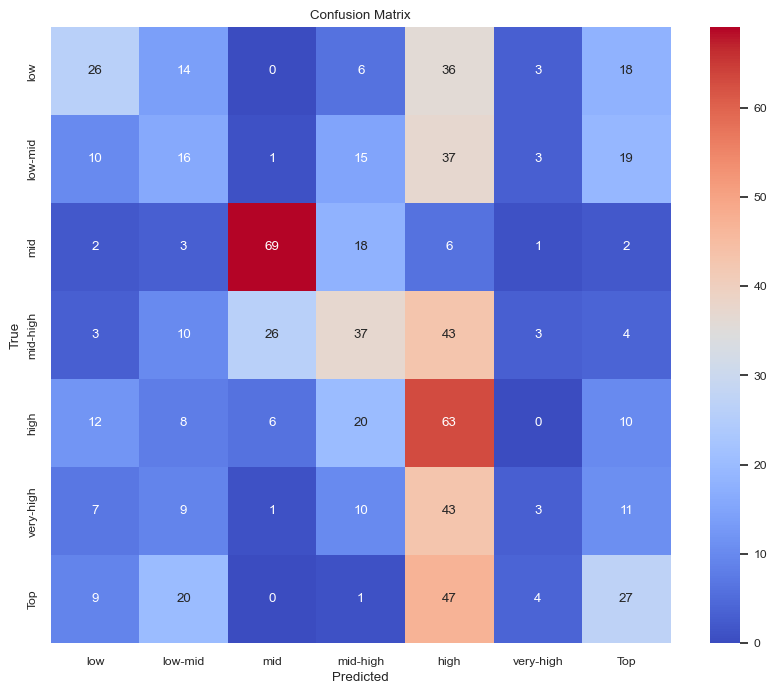

Classification Report:
              precision    recall  f1-score   support

         low       0.38      0.25      0.30       103
     low-mid       0.20      0.16      0.18       101
         mid       0.67      0.68      0.68       101
    mid-high       0.35      0.29      0.32       126
        high       0.23      0.53      0.32       119
   very-high       0.18      0.04      0.06        84
         Top       0.30      0.25      0.27       108

    accuracy                           0.32       742
   macro avg       0.33      0.31      0.30       742
weighted avg       0.33      0.32      0.31       742



In [34]:
# Generar la matriz de confusión
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=salary_labels, yticklabels=salary_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()

# Imprimir informe de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=salary_labels))

**Resultados y dicusión**

Según las puntuaciones, el clasificador Gradient Boosting es el mejor de los modelos probados, con una precisión de 0,32. Sin embargo, el rendimiento general de todos los modelos parece bastante bajo. Sin embargo, el rendimiento global de todos los modelos parece bastante bajo, lo que podría indicar que los modelos no son capaces de captar muy bien la relación entre las características y la variable objetivo (salario_ajustado).

Existen varias formas de mejorar el rendimiento de los modelos:

1- Ingeniería de características: Cree nuevas características o transforme las existentes para capturar mejor la relación entre las características y la variable objetivo. Por ejemplo, puede intentar combinar ciertas características categóricas o crear términos de interacción entre características.

2- Selección de características: Investigue la importancia de cada característica en el modelo y considere la posibilidad de eliminar las características menos importantes para reducir el ruido y mejorar el rendimiento del modelo.

3- Ajuste del modelo: Realice el ajuste de hiperparámetros para los modelos, especialmente para modelos complejos como RandomForestRegressor y GradientBoostingRegressor, para encontrar el mejor conjunto de hiperparámetros que puedan mejorar su rendimiento.

4- Probar diferentes modelos: Experimente con otros algoritmos de aprendizaje automático o pruebe métodos de conjunto, como el apilamiento o el ensamblaje, para ver si pueden producir mejores resultados.

5- Recopile más datos: Si es posible, recopila más datos para proporcionar a los modelos más información con la que aprender. Esto puede ayudar a mejorar su rendimiento.

Recuerda que el rendimiento de los modelos puede variar en función del conjunto de datos y del problema concreto, y que es esencial experimentar con distintos enfoques para encontrar la solución más adecuada.